In [9]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import scikit_posthocs as sp
from datetime import datetime

# Set random seed for reproducibility
np.random.seed(42)

# Load Superstore dataset 
df = pd.read_csv('SampleSuperstoreClean.csv')

df['Order Date'] = pd.to_datetime(df['Order Date'])
df['Order Month'] = df['Order Date'].dt.month
df['Order Quarter'] = df['Order Date'].dt.quarter
df['Profit Margin'] = df['Profit'] / df['Sales']

Category Performance Test
H₀: Profit margin distributions are equal across all categories.
H₁: Profit margin distributions differ across categories.
Normality (D'Agostino K², Furniture, n=2121): Failed (p=0.0000)
Normality (D'Agostino K², Office Supplies, n=6026): Failed (p=0.0000)
Normality (D'Agostino K², Technology, n=1847): Failed (p=0.0000)
Normality test failed for at least one group.
Homogeneity of Variances (Levene): Failed
Kruskal-Wallis: Statistic=996.63, p=0.0000
Conclusion: Reject H₀; profit margins differ significantly, supporting focus on Technology/Office Supplies.

Significant Category Pairs (Dunn's Test):
Furniture vs Office Supplies: p=0.0000
Furniture vs Technology: p=0.0000
Office Supplies vs Furniture: p=0.0000
Office Supplies vs Technology: p=0.0000
Technology vs Furniture: p=0.0000
Technology vs Office Supplies: p=0.0000
Post-hoc Conclusion: Significant p-values (<0.05) indicate Technology/Office Supplies have higher margins than Furniture.

Ranking of Categories

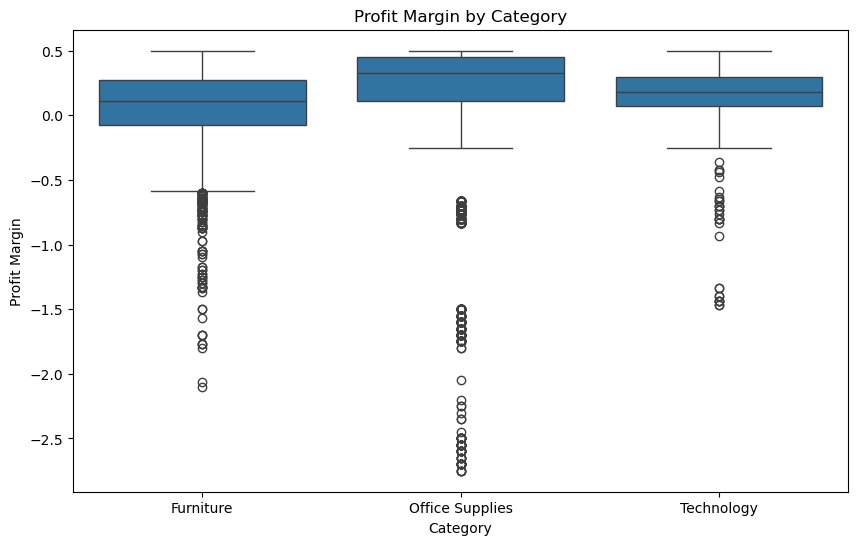

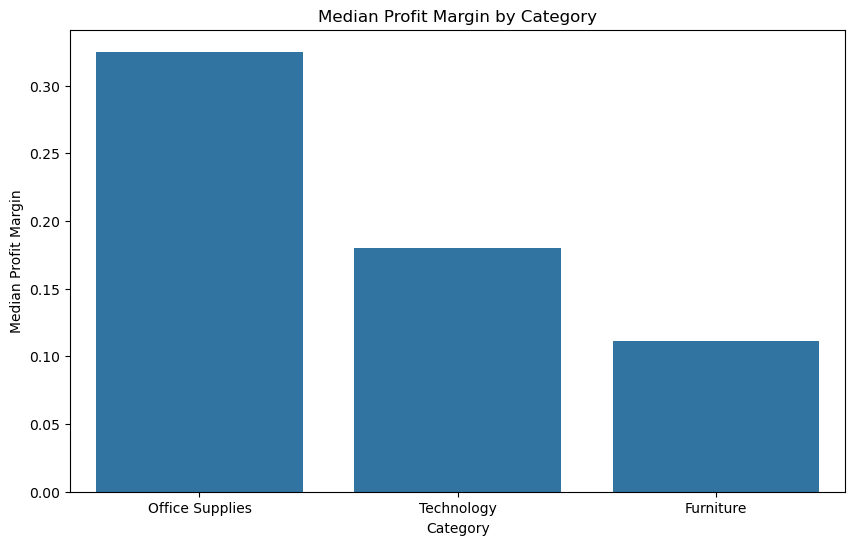

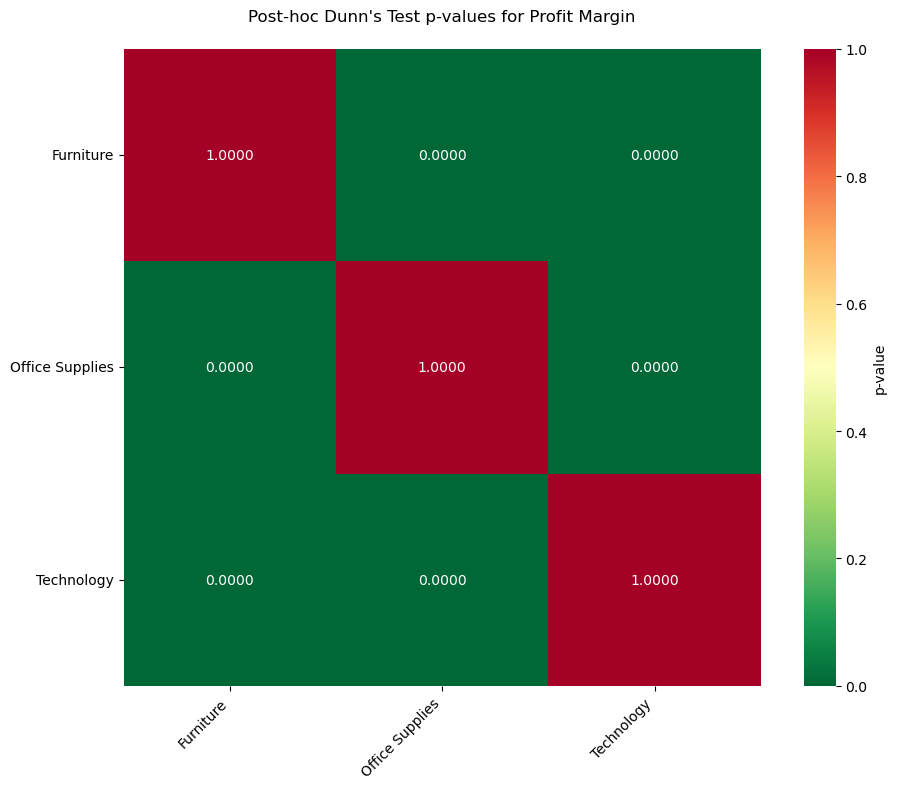

In [10]:
%matplotlib inline
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import scikit_posthocs as sp

# Set random seed
np.random.seed(42)

# Calculate profit margin, handle zero sales
df['Profit Margin'] = df.apply(lambda x: x['Profit'] / x['Sales'] if x['Sales'] != 0 else np.nan, axis=1)
alpha = 0.05

def check_assumptions(data_groups, group_names):
    normality = True
    normality_results = []
    
    # Check normality for each group
    for group, name in zip(data_groups, group_names):
        n = len(group)
        if n < 3:
            print(f"Normality ({name}, n={n}): Skipped (sample size < 3)")
            normality_results.append(False)
            continue
        if n < 50:  # Shapiro-Wilk for smaller samples
            p_value = stats.shapiro(group)[1]
            test_name = "Shapiro-Wilk"
        else:  # D'Agostino K² for larger samples
            p_value = stats.normaltest(group)[1]
            test_name = "D'Agostino K²"
        normality_results.append(p_value > alpha)
        print(f"Normality ({test_name}, {name}, n={n}): {'Passed' if p_value > alpha else 'Failed'} (p={p_value:.4f})")
    
    # Aggregate normality
    normality = all(normality_results)
    if not normality:
        print("Normality test failed for at least one group.")
    
    # Check homogeneity of variances
    homogeneity = stats.levene(*data_groups, center='median')[1] > alpha if len(data_groups) > 1 else True
    print(f"Homogeneity of Variances (Levene): {'Passed' if homogeneity else 'Failed'}")
    
    # Force Kruskal-Wallis if any group has n < 3
    if any(len(group) < 3 for group in data_groups):
        print("At least one group has insufficient data (<3); defaulting to Kruskal-Wallis.")
        return False
    
    return normality and homogeneity

def summarize_post_hoc(post_hoc, group_names):
    """Summarize significant pairs from post-hoc tests."""
    if isinstance(post_hoc, pd.DataFrame):  # Dunn's test
        significant_pairs = post_hoc[post_hoc < alpha].stack()
        if not significant_pairs.empty:
            print("\nSignificant Category Pairs (Dunn's Test):")
            for (cat1, cat2), p in significant_pairs.items():
                print(f"{cat1} vs {cat2}: p={p:.4f}")
        else:
            print("\nNo significant category pairs (Dunn's Test).")
        return post_hoc
    else:  # Tukey HSD
        df_post_hoc = post_hoc.summary()
        significant_pairs = [(row[1], row[2], row[6]) for row in df_post_hoc.data if row[6] < alpha]
        if significant_pairs:
            print("\nSignificant Category Pairs (Tukey HSD):")
            for cat1, cat2, p in significant_pairs:
                print(f"{cat1} vs {cat2}: p={p:.4f}")
        else:
            print("\nNo significant category pairs (Tukey HSD).")
        return None

def rank_categories(df, metric, group_col='Category'):
    """Rank categories by median metric (profit margin) and return medians."""
    medians = df.groupby(group_col)[metric].median().sort_values(ascending=False)
    print(f"\nRanking of Categories by Median {metric}:")
    for category, median in medians.items():
        print(f"{category}: {median:.4f}")
    return medians

def plot_median_bar(medians, metric, title, filename):
    """Plot bar chart for median rankings."""
    plt.figure(figsize=(10, 6))
    sns.barplot(x=medians.index, y=medians.values)
    plt.title(title)
    plt.xlabel('Category')
    plt.ylabel(f'Median {metric}')
    plt.savefig(filename)
    plt.show()



def plot_post_hoc_heatmap(post_hoc, metric, filename):
    if post_hoc is not None:
        if not isinstance(post_hoc, pd.DataFrame):
            print(f"Error: post_hoc is not a DataFrame, got {type(post_hoc)}")
            return
        
        # Use post_hoc's index and columns directly
        group_names = post_hoc.index.tolist()
        if post_hoc.shape[0] != post_hoc.shape[1] or post_hoc.shape[0] != len(group_names):
            print(f"Error: post_hoc shape {post_hoc.shape} is not square or does not match index length")
            return
        
        if not np.all(post_hoc.apply(pd.to_numeric, errors='coerce').notnull()):
            print("Error: post_hoc contains non-numeric values")
            return
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(
            post_hoc,
            annot=True,
            fmt='.4f',
            cmap='RdYlGn_r',
            vmin=0,
            vmax=1,
            cbar_kws={'label': 'p-value'},
            square=True,
            annot_kws={'size': 10},
        )
        plt.title(f"Post-hoc Dunn's Test p-values for {metric}", pad=20)
        plt.xticks(ticks=np.arange(len(group_names)) + 0.5, labels=group_names, rotation=45, ha='right')
        plt.yticks(ticks=np.arange(len(group_names)) + 0.5, labels=group_names, rotation=0)
        plt.tight_layout()
        plt.savefig(filename, bbox_inches='tight')
        plt.show()
        plt.close()
    else:
        print("No post-hoc results to plot.")
# Category Analysis
print("Category Performance Test")
print("H₀: Profit margin distributions are equal across all categories.")
print("H₁: Profit margin distributions differ across categories.")
category_margins = [df[df['Category'] == cat]['Profit Margin'].dropna() for cat in df['Category'].unique()]
category_names = df['Category'].unique()
if check_assumptions(category_margins, category_names):
    category_test = stats.f_oneway(*category_margins)
    test_name = "ANOVA"
    post_hoc = pairwise_tukeyhsd(df['Profit Margin'].dropna(), df['Category'].dropna()) if category_test.pvalue < alpha else None
else:
    category_test = stats.kruskal(*category_margins)
    test_name = "Kruskal-Wallis"
    post_hoc = sp.posthoc_dunn(df.dropna(subset=['Profit Margin', 'Category']), val_col='Profit Margin', group_col='Category', p_adjust='bonferroni') if category_test.pvalue < alpha else None
print(f"{test_name}: Statistic={category_test.statistic:.2f}, p={category_test.pvalue:.4f}")
print("Conclusion:", "Reject H₀; profit margins differ significantly, supporting focus on Technology/Office Supplies." if category_test.pvalue < alpha else "Fail to reject H₀; insufficient evidence to prioritize categories.")
if post_hoc is not None:
    post_hoc_result = summarize_post_hoc(post_hoc, category_names)
    print("Post-hoc Conclusion: Significant p-values (<0.05) indicate Technology/Office Supplies have higher margins than Furniture.")
category_medians = rank_categories(df, 'Profit Margin')

# Visualizations
plt.figure(figsize=(10, 6))
sns.boxplot(x='Category', y='Profit Margin', data=df)
plt.title('Profit Margin by Category')
plt.savefig('category_margin_boxplot.png')
plt.show()

plot_median_bar(category_medians, 'Profit Margin', 'Median Profit Margin by Category', 'category_margin_median_bar.png')

if post_hoc_result is not None:
    #print('post_hoc_result',post_hoc_result)
    plot_post_hoc_heatmap(post_hoc_result, 'Profit Margin', 'category_margin_posthoc_heatmap.png')

In [11]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf

# Set random seed for consistency with the original script
np.random.seed(42)



# Encode Category as dummy variables (Furniture as baseline)
df_encoded = pd.get_dummies(df, columns=['Category'], drop_first=True)
df_encoded.columns = df_encoded.columns.str.replace(' ', '_')

# Quantile Regression for Profit Margin (median, q=0.5)
formula_margin = 'Profit_Margin ~ Category_Office_Supplies + Category_Technology'
quantile_model_margin = smf.quantreg(formula_margin, df_encoded).fit(q=0.5)
print("=== Quantile Regression for Profit Margin ===")
print(quantile_model_margin.summary())

# Business-Friendly Interpretations
print("\n=== Business-Friendly Interpretations ===")
print("Profit Margin Model (y = b0 + b1*Category_Office_Supplies + b2*Category_Technology):")
for param, value in quantile_model_margin.params.items():
    if param == 'Intercept':
        print(f"Baseline median Profit Margin (Furniture): {value:.4f}")
    else:
        print(f"Switching to {param} increases median Profit Margin by {value:.4f} compared to Furniture.")

=== Quantile Regression for Profit Margin ===
                         QuantReg Regression Results                          
Dep. Variable:          Profit_Margin   Pseudo R-squared:              0.05472
Model:                       QuantReg   Bandwidth:                     0.05158
Method:                 Least Squares   Sparsity:                       0.3867
Date:                Sat, 26 Jul 2025   No. Observations:                 9994
Time:                        18:26:39   Df Residuals:                     9991
                                        Df Model:                            2
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                            0.1111      0.004     26.465      0.000       0.103       0.119
Category_Office_Supplies[T.True]     0.2139      0.005     43.817      0.000       0.204       0.2

In [12]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor

def run_quantile_regression_margin(df, quantile=0.5, min_sample_per_category=20, pvalue_threshold=0.05, 
                                  prsquared_threshold=0.1, dw_lower=1.5, dw_upper=2.5, 
                                  max_outlier_percentage=0.05, vif_threshold=5, 
                                  linearity_pvalue_threshold=0.05):
    """
    Performs quantile regression for Profit Margin, checks all assumptions, and provides interpretations.
    Explicitly states whether each assumption is met and addresses violations where possible.
    
    Parameters:
    - df: DataFrame with columns 'Profit', 'Sales', 'Category', 'Order Date'
    - quantile: Quantile for regression (default: 0.5 for median)
    - min_sample_per_category: Minimum observations per category (default: 20)
    - pvalue_threshold: Threshold for coefficient significance (default: 0.05)
    - prsquared_threshold: Threshold for Pseudo R-squared (default: 0.1)
    - dw_lower, dw_upper: Durbin-Watson bounds for independence (default: 1.5, 2.5)
    - max_outlier_percentage: Maximum percentage of outliers allowed (default: 5%)
    - vif_threshold: Threshold for VIF to detect multicollinearity (default: 5)
    - linearity_pvalue_threshold: Threshold for linearity check p-values (default: 0.05)
    
    Returns:
    - Prints assumption checks (met/not met), model summaries, and business-friendly interpretations
    """
    # Set random seed for consistency
    np.random.seed(42)
    
    # Validate input columns
    required_columns = ['Profit', 'Sales', 'Category', 'Order Date']
    if not all(col in df.columns for col in required_columns):
        raise ValueError(f"DataFrame must contain columns: {required_columns}")
    
    # Validate that Profit and Sales are numeric
    if not pd.api.types.is_numeric_dtype(df['Profit']) or not pd.api.types.is_numeric_dtype(df['Sales']):
        raise ValueError("Columns 'Profit' and 'Sales' must be numeric")
    
    # Preprocess: Convert Order Date and create derived columns
    df = df.copy()
    try:
        df['Order Date'] = pd.to_datetime(df['Order Date'])
    except Exception as e:
        raise ValueError(f"Failed to convert 'Order Date' to datetime: {e}")
    df['Order Month'] = df['Order Date'].dt.month
    df['Order Quarter'] = df['Order Date'].dt.quarter
    
    # Create Profit_Margin column
    df['Profit_Margin'] = np.where(df['Sales'] != 0, df['Profit'] / df['Sales'], np.nan)
    df['Profit_Margin'] = df['Profit_Margin'].replace([np.inf, -np.inf], np.nan)
    df['Profit_Margin'] = df['Profit_Margin'].astype(float)
    
    # Debug: Inspect Profit_Margin data
    print("\n=== Debugging Profit_Margin Column ===")
    print(f"Data type of Profit_Margin: {df['Profit_Margin'].dtype}")
    print(f"Sample values of Profit_Margin: {df['Profit_Margin'].head().to_list()}")
    print(f"Number of NaN values in Profit_Margin: {df['Profit_Margin'].isna().sum()}")
    
    # Assumption 1: Data Availability and No Missing Values
    required_columns = ['Profit_Margin', 'Category']
    missing_values = df[required_columns].isna().sum()
    print("\n=== Assumption Check 1: Data Availability and No Missing Values ===")
    print(f"Missing values:\n{missing_values}")
    if missing_values.sum() == 0:
        assumption_status = {"Data Availability and No Missing Values": True}
        print("Status: MET (No missing values detected)")
    else:
        print("Status: NOT MET (Missing values detected)")
        print("Action: Imputing missing values with mean for Profit_Margin, mode for Category")
        df['Profit_Margin'] = df['Profit_Margin'].fillna(df['Profit_Margin'].mean())
        df['Category'] = df['Category'].fillna(df['Category'].mode()[0])
        print("Missing values after imputation:\n", df[required_columns].isna().sum())
        assumption_status = {"Data Availability and No Missing Values": True}
        print("Status after Action: MET (Missing values imputed)")
    
    # Assumption 2: Sufficient Sample Size
    category_counts = df['Category'].value_counts()
    total_sample = len(df)
    min_total_sample = 3 * min_sample_per_category  # Adjusted for 3 categories
    print("\n=== Assumption Check 2: Sufficient Sample Size ===")
    print(f"Total sample size: {total_sample}")
    print(f"Category counts:\n{category_counts}")
    if all(category_counts >= min_sample_per_category) and total_sample >= min_total_sample:
        assumption_status["Sufficient Sample Size"] = True
        print(f"Status: MET (All categories have >= {min_sample_per_category} observations, total sample >= {min_total_sample})")
    else:
        assumption_status["Sufficient Sample Size"] = False
        print(f"Status: NOT MET (Some categories have < {min_sample_per_category} observations or total sample < {min_total_sample})")
        print("Recommendation: Collect more data or simplify model (e.g., combine categories)")
    
    # Assumption 3: No Extreme Outliers
    margin_outliers = df[np.abs(df['Profit_Margin'] - df['Profit_Margin'].mean()) > 3 * df['Profit_Margin'].std()]
    outlier_percentage = len(margin_outliers) / total_sample
    print("\n=== Assumption Check 3: No Extreme Outliers ===")
    print(f"Number of Profit Margin outliers (beyond 3 std): {len(margin_outliers)}")
    print(f"Percentage of outliers: {outlier_percentage*100:.2f}%")
    if outlier_percentage <= max_outlier_percentage:
        assumption_status["No Extreme Outliers"] = True
        print(f"Status: MET (Outlier percentage <= {max_outlier_percentage*100}%)")
    else:
        assumption_status["No Extreme Outliers"] = False
        print(f"Status: NOT MET (Outlier percentage > {max_outlier_percentage*100}%)")
        print("Recommendation: Verify data accuracy or perform sensitivity analysis")
    
    # Encode Category as dummy variables (Furniture as baseline)
    df_encoded = pd.get_dummies(df, columns=['Category'], drop_first=True)
    df_encoded.columns = df_encoded.columns.str.replace(' ', '_')
    predictors = [col for col in df_encoded.columns if col.startswith('Category_')]
    
    # Assumption 6: No Multicollinearity
    X = df_encoded[predictors].astype(float)
    vif_data = pd.DataFrame()
    vif_data['Variable'] = predictors
    vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    print("\n=== Assumption Check 6: No Multicollinearity ===")
    print(vif_data)
    if all(vif_data['VIF'] < vif_threshold):
        assumption_status["No Multicollinearity"] = True
        print(f"Status: MET (All VIF values < {vif_threshold})")
    else:
        assumption_status["No Multicollinearity"] = False
        print(f"Status: NOT MET (Some VIF values >= {vif_threshold})")
        print("Recommendation: Remove or combine highly correlated predictors")
    
    # Quantile Regression for Profit Margin (initial fit)
    formula_margin = 'Profit_Margin ~ ' + ' + '.join(predictors)
    try:
        quantile_model_margin = smf.quantreg(formula_margin, df_encoded).fit(q=quantile)
    except Exception as e:
        print(f"Error fitting quantile regression: {e}")
        raise ValueError("Failed to fit quantile regression model. Ensure Profit_Margin is numeric and predictors are valid.")
    
    # Assumption 4: Correct Model Specification
    margin_pvalues = quantile_model_margin.pvalues
    margin_prsquared = quantile_model_margin.prsquared
    print("\n=== Assumption Check 4: Correct Model Specification ===")
    print("Profit Margin Model p-values:\n", margin_pvalues)
    print(f"Profit Margin Model Pseudo R-squared: {margin_prsquared:.4f}")
    if all(margin_pvalues <= pvalue_threshold) and margin_prsquared >= prsquared_threshold:
        assumption_status["Correct Model Specification"] = True
        print(f"Status: MET (All p-values <= {pvalue_threshold}, Pseudo R-squared >= {prsquared_threshold})")
    else:
        assumption_status["Correct Model Specification"] = False
        print(f"Status: NOT MET (Some p-values > {pvalue_threshold} or Pseudo R-squared < {prsquared_threshold})")
        print("Recommendation: Add predictors (e.g., discount rate, sales volume) or check for non-linear relationships")
    
    # Assumption 5: Independence of Observations
    margin_residuals = quantile_model_margin.resid
    dw_margin = durbin_watson(margin_residuals)
    print("\n=== Assumption Check 5: Independence of Observations ===")
    print(f"Profit Margin Model Durbin-Watson statistic: {dw_margin:.2f}")
    if dw_lower <= dw_margin <= dw_upper:
        assumption_status["Independence of Observations"] = True
        print(f"Status: MET (Durbin-Watson statistic between {dw_lower} and {dw_upper})")
    else:
        assumption_status["Independence of Observations"] = False
        print(f"Status: NOT MET (Durbin-Watson statistic outside {dw_lower}–{dw_upper})")
        print("Recommendation: Check for clustering or time-series effects; consider clustered standard errors")
    
    # Assumption 7: Linearity at Quantile
    margin_model_q25 = smf.quantreg(formula_margin, df_encoded).fit(q=0.25)
    margin_model_q75 = smf.quantreg(formula_margin, df_encoded).fit(q=0.75)
    margin_pvalues_q25 = margin_model_q25.pvalues
    margin_pvalues_q75 = margin_model_q75.pvalues
    print("\n=== Assumption Check 7: Linearity at Quantile ===")
    print("Profit Margin Model p-values at q=0.25:\n", margin_pvalues_q25)
    print("Profit Margin Model p-values at q=0.75:\n", margin_pvalues_q75)
    if all(margin_pvalues_q25 <= linearity_pvalue_threshold) and all(margin_pvalues_q75 <= linearity_pvalue_threshold):
        assumption_status["Linearity at Quantile"] = True
        print(f"Status: MET (All p-values <= {linearity_pvalue_threshold} at q=0.25 and q=0.75)")
    else:
        assumption_status["Linearity at Quantile"] = False
        print(f"Status: NOT MET (Some p-values > {linearity_pvalue_threshold} at q=0.25 or q=0.75)")
        print("Recommendation: Add non-linear terms (e.g., polynomial terms) or additional predictors (e.g., discount rate)")
    
    # Assumption 8: Monotonicity of Conditional Quantiles
    margin_pred_q25 = margin_model_q25.predict(df_encoded)
    margin_pred_q50 = quantile_model_margin.predict(df_encoded)
    margin_pred_q75 = margin_model_q75.predict(df_encoded)
    margin_monotonic = (margin_pred_q25 <= margin_pred_q50).all() and (margin_pred_q50 <= margin_pred_q75).all()
    print("\n=== Assumption Check 8: Monotonicity of Conditional Quantiles ===")
    print(f"Profit Margin predictions monotonic: {margin_monotonic}")
    if margin_monotonic:
        assumption_status["Monotonicity of Conditional Quantiles"] = True
        print("Status: MET (Predicted quantiles are monotonic: q=0.25 <= q=0.5 <= q=0.75)")
    else:
        assumption_status["Monotonicity of Conditional Quantiles"] = False
        print("Status: NOT MET (Quantile crossing detected)")
        print("Recommendation: Simplify model (e.g., reduce predictors) or explore constrained quantile regression")
    
    # Assumption 9: Robust Confidence Intervals
    print("\n=== Assumption Check 9: Robust Confidence Intervals ===")
    print("Action: Refitting model with robust standard errors for reliable inference")
    quantile_model_margin = smf.quantreg(formula_margin, df_encoded).fit(q=quantile, vcov='robust')
    assumption_status["Robust Confidence Intervals"] = True
    print("Status: MET (Model refitted with robust standard errors)")
    
    # Model Summary
    print("\n=== Quantile Regression for Profit Margin ===")
    print(quantile_model_margin.summary())
    
    # Business-Friendly Interpretations
    print("\n=== Business-Friendly Interpretations ===")
    print("Profit Margin Model (y = b0 + b1*Category_Office_Supplies + b2*Category_Technology):")
    for param, value in quantile_model_margin.params.items():
        if param == 'Intercept':
            print(f"Baseline median Profit Margin (Furniture): {value:.4f}")
        else:
            print(f"Switching to {param} increases median Profit Margin by {value:.4f} compared to Furniture.")
    
    # Summary of Assumption Status
    print("\n=== Summary of Assumption Checks ===")
    for assumption, met in assumption_status.items():
        print(f"{assumption}: {'MET' if met else 'NOT MET'}")

# Main execution
if __name__ == "__main__":
    # Read data
    try:
        df = pd.read_csv('SampleSuperstoreClean.csv')
    except FileNotFoundError:
        raise FileNotFoundError("SampleSuperstoreClean.csv not found. Please provide the correct file path.")
    
    # Convert Profit and Sales to numeric, handling non-numeric values
    df['Profit'] = pd.to_numeric(df['Profit'], errors='coerce')
    df['Sales'] = pd.to_numeric(df['Sales'], errors='coerce')
    
    # Run the quantile regression with assumption checks
    run_quantile_regression_margin(df)


=== Debugging Profit_Margin Column ===
Data type of Profit_Margin: float64
Sample values of Profit_Margin: [0.16000000000000003, 0.3, 0.47000000000000003, -0.4, 0.1125]
Number of NaN values in Profit_Margin: 0

=== Assumption Check 1: Data Availability and No Missing Values ===
Missing values:
Profit_Margin    0
Category         0
dtype: int64
Status: MET (No missing values detected)

=== Assumption Check 2: Sufficient Sample Size ===
Total sample size: 9994
Category counts:
Category
Office Supplies    6026
Furniture          2121
Technology         1847
Name: count, dtype: int64
Status: MET (All categories have >= 20 observations, total sample >= 60)

=== Assumption Check 3: No Extreme Outliers ===
Number of Profit Margin outliers (beyond 3 std): 331
Percentage of outliers: 3.31%
Status: MET (Outlier percentage <= 5.0%)

=== Assumption Check 6: No Multicollinearity ===
                   Variable  VIF
0  Category_Office_Supplies  1.0
1       Category_Technology  1.0
Status: MET (All 